### Ejercicio 3

#### Definicion de funciones principales

In [113]:
import random
import matplotlib.pyplot as plt
from math import log
from math import ceil
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')


In [114]:
# parametros

PRECISION = 3
X_MIN = -10
X_MAX = 10
Y_MIN = 0
Y_MAX = 20

# Calculo la longitud del cromosoma para cada variable
LONGITUD_CROMOSOMAX = ceil(log((X_MAX - X_MIN)*10**PRECISION,2))
LONGITUD_CROMOSOMAY = ceil(log((Y_MAX - Y_MIN)*10**PRECISION,2))

LONGITUD_CROMOSOMA = LONGITUD_CROMOSOMAX + LONGITUD_CROMOSOMAY
TAMANIO_POBLACION = 4

TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness

OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2


In [115]:
#  -----------------------------------------------------------------
# funcion para mapear el valor binario a un rango [X_MIN, X_MAX]
#  -----------------------------------------------------------------
def binario_a_decimal(cromosoma):
    # print(cromosoma)
    decimalX = int(cromosoma[:LONGITUD_CROMOSOMAX], 2)
    decimalY = int(cromosoma[LONGITUD_CROMOSOMAX:], 2)
    x = X_MIN + decimalX * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMAX) - 1)
    y = Y_MIN + decimalY * (Y_MAX - Y_MIN) / ((2 ** LONGITUD_CROMOSOMAY) - 1)
    return x, y

#  -----------------------------------------------------------------
# Aqui en las proximas lineas se puede ver que mi funcion objetivo es
# a veces diferente de mi funcion fitness, depende del problema a resolver
#  -----------------------------------------------------------------


#  -----------------------------------------------------------------
# funcion objetivo x^2
#  -----------------------------------------------------------------
def funcion_objetivo(x, y):
    return 7.7 + 0.15*x + 0.22*y - 0.05*x**2 - 0.016*y**2 - 0.007*x*y


#  -----------------------------------------------------------------
# funcion fitness o tambien llamada funcion de aptitud
#  -----------------------------------------------------------------
def aptitud(cromosoma):
    x, y = binario_a_decimal(cromosoma)    
    if OBJ == 'MIN':
        return 1 / (funcion_objetivo(x,y) + EPSILON)
    elif OBJ =='MAX':
        return funcion_objetivo(x,y)


#  -----------------------------------------------------------------
# se inicializa la poblacion
#  -----------------------------------------------------------------
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion = []
    for tp in range(tamanio_poblacion):
        cromosoma = ''
        for lc in range(longitud_cromosoma):
            cromosoma = cromosoma+str(random.randint(0, 1))
        poblacion.append(cromosoma)
    return poblacion

#  -----------------------------------------------------------------
# seleccion por ruleta
#  -----------------------------------------------------------------
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for individuo in poblacion:
        prob = aptitud(individuo) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma += prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i]


#  -----------------------------------------------------------------
# seleccion por torneo
#  -----------------------------------------------------------------
def seleccion_torneo(poblacion, tamanio_torneo=TAMANIO_TORNEO):
    progenitores = []
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = max(candidatos, key=aptitud)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores


# -----------------------------------------------------------------
# seleccion por ranking lineal
# -----------------------------------------------------------------
def seleccion_ranking(poblacion):
    # se calcula la aptitud de cada individuo
    aptitudes = []
    for individuo in poblacion:
        aptitudes.append(aptitud(individuo))

    # se ordena la poblacion por aptitud (mayor aptitud es mejor)
    # x es la tupla de zip, de la cual se toma el segundo elemento (x[1]) para
    # ser ordenada la tupla por ese elemento, en este caso por aptitud
    poblacion_ordenada = sorted(zip(poblacion, aptitudes), key=lambda x: x[1])

    # se calcula probabilidades segun el ranking lineal
    N = len(poblacion)
    s = 1.7  # Factor de seleccion comunmente usado
    probabilidades = []
    for i in range(N):
        prob = (2 - s) / N + (2 * i * (s - 1)) / (N * (N - 1))
        probabilidades.append(prob)

    # se selecciona un progenitor basado en las probabilidades
    r = random.random()
    suma = 0
    for i in range(N):
        suma = suma + probabilidades[i]
        if r <= suma:
            return poblacion_ordenada[i][0]  # se retornar el cromosomas

#  -----------------------------------------------------------------
# cruce monopunto con probabilidad de cruza pc = TASA_CRUCE
#  -----------------------------------------------------------------
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = progenitor1[:punto_cruce] + progenitor2[punto_cruce:]
        descendiente2 = progenitor2[:punto_cruce] + progenitor1[punto_cruce:]
    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2


#  -----------------------------------------------------------------
# mutacion
#  -----------------------------------------------------------------
def mutacion(cromosoma, tasa_mutacion):
    cromosoma_mutado = ""
    for bit in cromosoma:
        if random.random() < tasa_mutacion:
            cromosoma_mutado = cromosoma_mutado + str(int(not int(bit)))
        else:
            cromosoma_mutado = cromosoma_mutado + bit
    return cromosoma_mutado


In [116]:
#  -----------------------------------------------------------------
# aplicación de operadores geneticos
#  -----------------------------------------------------------------
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones, seleccion, elitismo, imprimir=True):
    poblacion = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    
    # print(poblacion) #-------------------------------------------------->

    mejor_funcion_objetivo_generaciones = []  # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        if imprimir==True: print("Generación:", generacion + 1)

        # se calcula aptitud total para luego
        aptitud_total = sum(aptitud(cromosoma) for cromosoma in poblacion)

        if imprimir==True: print("Aptitud total:", aptitud_total)

        #  -----------------------------------------------------------------
        
        if seleccion == 'ruleta':
            # seleccion de progenitores con el metodo ruleta
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ruleta(poblacion, aptitud_total))
        
        elif seleccion == 'torneo':            
            # seleccion de progenitores con el metodo de torneo
            progenitores = seleccion_torneo(poblacion)
        
        elif seleccion == 'ranking':            
            # seleccion de progenitores con el metodo de ranking lineal
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ranking(poblacion))
        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        if elitismo:
            # Aquí se aplica elitismo
            # Se reemplazan los peores cromosomas con los mejores progenitores
            poblacion.sort(key=aptitud)  # se ordena la poblacion por aptitud en forma ascendente
            # se ordena los descendientes por aptitud en forma descendente
            descendientes_mutados.sort(key=aptitud, reverse=True)
            for i in range(len(descendientes_mutados)):
                if aptitud(descendientes_mutados[i]) > aptitud(poblacion[i]):
                    poblacion[i] = descendientes_mutados[i]                

        else: # si no hay elitismo, todos los descendientes pasan a ser la nueva poblacion
            poblacion = descendientes_mutados

        # Mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el maximo para la aptitud
        mejor_funcion_objetivo_generaciones.append(funcion_objetivo(*binario_a_decimal(mejor_individuo)))

        if imprimir == True:
            print("mi", mejor_individuo)
            print("Mejor individuo:", binario_a_decimal(mejor_individuo), "Aptitud:", aptitud(mejor_individuo))
            print("_________________________________________________________________________________")

    if imprimir ==True:
        # Graficar la evolución de la aptitud
        plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
        plt.xlabel('Generación')
        plt.ylabel('Valor de la Función Objetivo')
        plt.title('Curva de Convergencia del Algoritmo Genético')
        plt.grid(True)
        plt.show()
    return max(poblacion, key=aptitud)  # se retorna el mejor individuo


#### Ruleta

_________________________________________________________________________________

Generación: 1
Aptitud total: 27.33866194692505
mi 101000010101101000100110110001
Mejor individuo: (2.605975524155401, 1.5143284401989807) Aptitud: 8.020177993890671
_________________________________________________________________________________
Generación: 2
Aptitud total: 31.78609286490446
mi 101000010101101000100110110001
Mejor individuo: (2.605975524155401, 1.5143284401989807) Aptitud: 8.020177993890671
_________________________________________________________________________________
Generación: 3
Aptitud total: 31.861979940026412
mi 100001010101111000100100110001
Mejor individuo: (0.4196295052949619, 1.436201055940428) Aptitud: 8.032882730075825
_________________________________________________________________________________
Generación: 4
Aptitud total: 32.019833382759934
mi 100001010101111000100100110001
Mejor individuo: (0.4196295052949619, 1.436201055940428) Aptitud: 8.032882730075825
_________

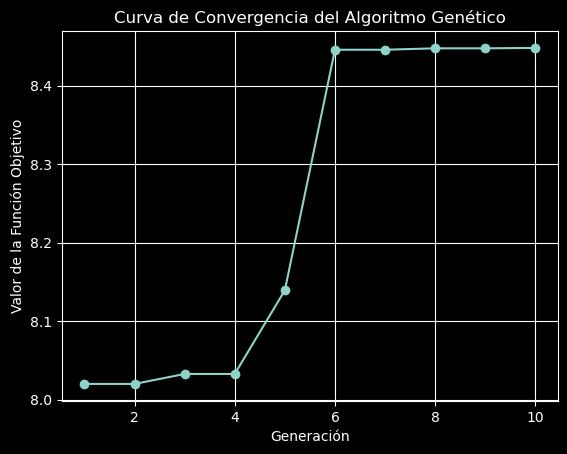

Mejor solución: (0.43671987060151984, 8.421277504806666) Aptitud: 8.44822200781599


In [121]:
#Parametros
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

#### Torneo

_________________________________________________________________________________

Generación: 1
Aptitud total: 24.791772868608703
mi 1000001011001010110111
Mejor individuo: (0.2198339032730825, 6.790425012212995) Aptitud: 8.476244931935376
_________________________________________________________________________________
Generación: 2
Aptitud total: 30.271715181748693
mi 1001011100101010110010
Mejor individuo: (1.8124084025403029, 6.741573033707865) Aptitud: 8.478055820127349
_________________________________________________________________________________
Generación: 3
Aptitud total: 32.994495835410596
mi 1001011100101010110010
Mejor individuo: (1.8124084025403029, 6.741573033707865) Aptitud: 8.478055820127349
_________________________________________________________________________________
Generación: 4
Aptitud total: 33.90547325920974
mi 1001001111001001110101
Mejor individuo: (1.5486077186126046, 6.1455788959452855) Aptitud: 8.493499345736693
_______________________________________

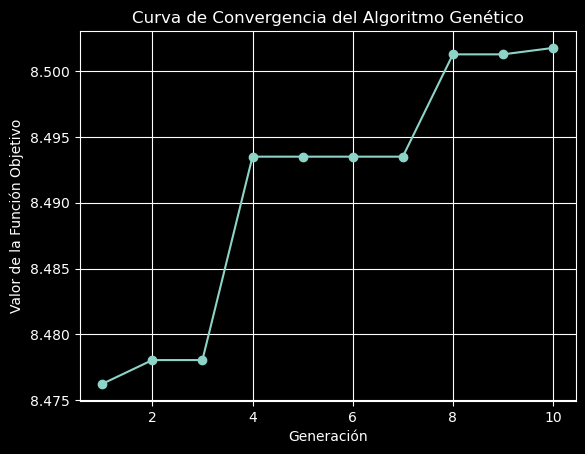

Mejor solución: (1.1968734733756712, 7.220322423058134) Aptitud: 8.501755067587322


In [ ]:
#Parametros
ELITISMO = False # True o False
SELECCION = 'torneo' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))